# Workshop 3: Exploring IllustrisTNG simulations to derive observationally comparable star formation rates and metallicities

## Notebook 3: Deriving observationally comparable luminosity-weighted ages and SFRs

Created by Bryanne McDonough and Olivia Curtis

In this notebook, we will use the particle data we pulled for one TNG galaxy in Notebook 1 to demonstrate how the particle data can be used to obtain observationally comparable parameters related to star formation.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import iapi_TNG as iapi
#TNG saves particle birth times as scale factors
#we'll use astropy to convert these into lookback times to get ages
from astropy.cosmology import Planck15
import astropy.units as u



### Update this directory for your machine ####
dirc='/projectnb/res-star/TNG_workshop/'

h=0.6774 # from notebook 1 or data background

First, load the galaxy catalog that we made in Notebook 1 and get the relevent fields that we will be using here.

In [3]:
currentdirc=!pwd
print(currentdirc)
#dirc= ' '.join(currentdirc) + '/TNG_workshop_data/'
dirc = ' '.join(currentdirc) + '/backup_data/'
print(f"current dirc {dirc}")

dat=np.load(dirc+'galcat.npy', allow_pickle=True).item()
IDs=dat['subID']
gal_pos= dat['pos']

['/Users/alexpoulin/Downloads/git/TNG/TNG_workshop']
current dirc /Users/alexpoulin/Downloads/git/TNG/TNG_workshop/backup_data/


Next, load the particle data for the cutout that we saved for galaxy subID 565261 in Notebook 1.

In [4]:
my_gal = 565261 #subID of the galaxy cutout you obtained

#ID into galcat for my_gal
sub_ind= np.where(IDs==my_gal)[0][0]
print(sub_ind)
parttype='stars'

#path to cutout file
cut_file = dirc+'cutouts/'+parttype+'_'+str(my_gal)+'.hdf5'

#pull particle data out of the hdf5 cutout file
with h5py.File(cut_file,'r') as f:
    #change PartType4 to PartType0 if working with gas particles
    #all units can be found in the 

    mass = np.asarray(f['PartType4']['Masses']) # in units of 10^10 M_sun h^-1
    SF_scale = np.asarray(f['PartType4']['GFM_StellarFormationTime']) #given as scale factor
    iMass = np.asarray(f['PartType4']['GFM_InitialMass']) # in units of 10^10 M_sun h^-1
    
    #get particle positions to make aperture cuts later
    part_pos = np.asarray(f['PartType4']['Coordinates'])  #in units of ckpc/h (comoving kiloparsecs)
    #for deriving SFRs, birth positions are also avaialable, but that isn't information avaialble in observations
    
    #in this example, we will use r-band magnitude for luminosity weighting
    #use a different band by selecting a different column from GFM_StellarPhotometrics
    #check data specifications to see which column corresponds to which band
    rmag = np.asarray(f['PartType4']['GFM_StellarPhotometrics'][:,5])

24957


### Converting scale factors to ages

The scale factor, a, is related to redshift by: $\frac{1}{a} = 1+z $.

TNG uses Planck15 cosmology (from background information), we will use Astropy to convert redshifts into lookback times.

First, wind-phase particles have scale factors <0, so we should exclude those.

In [5]:
wh_stars = np.nonzero((SF_scale>0)) #select only non-wind particles
mass=mass[wh_stars] #instanteous mass of stellar particle
SF_scale=SF_scale[wh_stars] #scale factor when formed
iMass = iMass[wh_stars] # mass of particle when formed
part_pos = part_pos[wh_stars] #instantaneous positions
rmag= rmag[wh_stars] # r-band magnitude

Next, conver our scale factors into redshifts

In [6]:
# convert scale factor to redshift
SF_z=1/SF_scale-1

Then, use astropy to get ages, given in Gyr, divide out the unit for later computation

In [9]:
ages=Planck15.lookback_time(SF_z)/u.Gyr #ages are still in Gyr, just without the unit astropy attaches
print(len(ages))
print(part_pos[0,:])
print(part_pos.shape)

517
[62338.21320145 64240.8441158  41446.04025474]
(517, 3)


#### Exercise: Create a histogram of the ages in this galaxy


The shape of hist is:  (100, 100)


(62330.0, 62360.0)

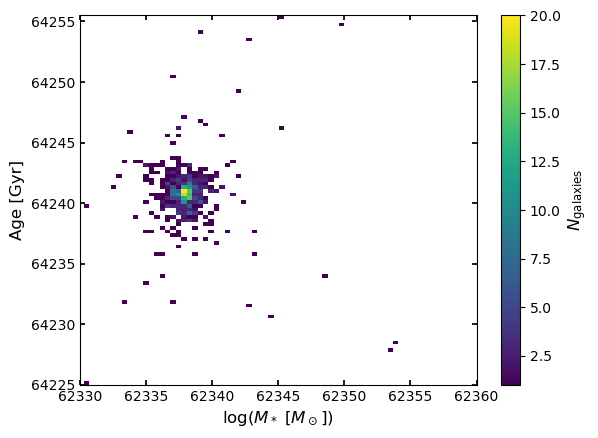

In [29]:
### Create a histogram of the stellar ages in this galaxy ###

'''
hist, xedges, yedges, image = plt.hist2d(logmass[np.isfinite(logSFR_10)], \
                                         logSFR_10[np.isfinite(logSFR_10)], \
                                         bins=100, cmin=1)
                                         '''
##histogram of stellar ages based on position in the galaxy
hist, xedges, yedges, image = plt.hist2d(part_pos[:,0], \
                                         part_pos[:,1], \
                                         bins=100, cmin=1)
'''
hist, xedges, yedges, image = plt.hist2d(np.log10(mass), \
                                            ages.value, \
                                            bins=100, cmin=1)
'''

print("The shape of hist is: ", hist.shape)

cbar=plt.colorbar()
cbar.set_label('$N_{\mathrm{galaxies}}$', rotation=90, fontsize=12)

#Label the axes
plt.xlabel('log($M_*$ [$M_\odot$])',fontsize=12)
plt.ylabel('Age [Gyr]',fontsize=12)

#Change the style of the tick marks
plt.tick_params(axis='both', direction='in', \
                width=1.25, labelsize='medium', \
                which='both', top=True, right=True)

plt.xlim(62330, 62360)


### Obtain time-averaged SFRs
Now that we have ages, we can compute SFRs by finding the mass of stars that was formed in the last X years.

In [12]:
#find stars formed in the last 10 Myrs, remember ages is in Gyr
wh10 = np.nonzero((ages<=0.02))
print(len(ages[wh10]))

0


The H-alpha star formation tracers makes use of stars that are 10-20 Myr old. Would this galaxy have detectable star formation in H-alpha?

If no star formation has happened in the last 20 Myr, we'll need a longer timescale to obain a non-zero SFR. The D4000-Angstrom break SF tracer roughly traces stars with ages ~100-200 Myr.

In [13]:
#Adopt a 100 Myr timescale
wh100 = np.nonzero((ages<=0.1))
print(len(ages[wh100]))

2


#### Exercise: determine the coefficient needed to convert mass formed into a SFR

Here, we use the mass of the stellar particles when they formed, for the reasons outlined in the erratum to Donnari et al (2019): https://academic.oup.com/mnras/article/489/3/3036/5558254.

We will first take the sum of all stellar mass that formed within the last 100 Myr.

In [14]:
mass100= np.sum(iMass[wh100])

Next, we will define t to be the factor that mass100 should be multiplied by to have units of solar masses per year. Fill in the following code block with this definition.

In [19]:
### Hint: You will need to take into account the timescale and the units of mass100 ###

t=100/h #Fill in the code here
print(f"t is {t}")

SFR100 =t*mass100
print(np.log10(SFR100), 'M_sun/yr')
#Answer: t=100/h  : mass100 in solar masses: mass100/h*10**10; 100 Myr in yr: (100*10**6)
#when mass in solar masses is divided by the timescale, reduces to: 100/h

t is 147.62326542663124
-1.666580632619436 M_sun/yr


#### Extension: Determine SFR for a different timescale

Consider timescales of popular SFR tracers 

In [20]:
#Hint: you'll need a new factor 

See more about time-averaged SFRs from the TNG simulation and see the effect on the star-forming main sequence in Donnari et al (2019): https://academic.oup.com/mnras/article/485/4/4817/5376508.

See Section 4 of Caplar & Tacchella (2019) for a summary of common SFR tracers and considerations regarding the timescales of those tracers: https://ui.adsabs.harvard.edu/abs/2019MNRAS.487.3845C/abstract. 

### Determining luminosity-weighted ages
Luminosity-weighted age is another measurement that can be found in observational studies. Instead of finding an overall average age, luminosity-weighting emphasizes recent star formation, as the most luminous stars have the shortest lifetimes.

The luminosity-weighted age, ${\rm age_L}$, in the simulation is defined by: $\log_{10} {\rm age_L} = <x> = \frac{\Sigma_k L_k x_k}{\Sigma_k L_k} $,

where $x_k$ is the $\log_{10}$ of the kth particle's formation age and $L_k$ is the r-band luminosity of the kth particle.

While we are using r-band luminosities here, this can be altered in order to better compare to an observational study.

In [21]:
# compute the luminosity weighted age over all stellar particles in this galaxy
#remember to log the ages after converting Gyr to yrs
ageL = np.sum(rmag*np.log10(ages*10**9))/np.sum(rmag)
print('log_{10}=', ageL)

log_{10}= 9.586869003104727


Advice for efficiently computing luminosity-weighted ages over several galaxies in radial bins: you can construct radial profiles of ${\rm age_L}$ for individual galaxies and save the top and bottom sums separately. When binning galaxies together, you can sum the sums, rather than summing over all particles in each galaxy. 

### Making aperture cuts

Observations are often computing SFRs or luminosity-weighted ages in certain apertures. For example, the SDSS fiber aperture corresponds roughly to 5 kpc. In order to make aperture cuts, we'll need to get the distances of particles to the center of the galaxy. 

Getting relative distances is complicated by the fact that TNG is simulating within a repeating box. That is, it's possible that this galaxy exists at the "edge" of the box. As an illustrative example, if the box length, one particle could have x=74.9999 and another in the same galaxy could have x=0.00001. 

Here's some code to get relative distances, accounting for the repeating box:

In [22]:
#get box length
baseUrl = 'http://www.tng-project.org/api/'
sim='TNG100-1' ### update if you are looking at a different simulation ###
simUrl = baseUrl+sim
simdata = iapi.get(simUrl)
boxsize=simdata['boxsize']
print(boxsize)
#should be 75000 kpc/h

75000.0


In [23]:
#get position of this galaxy
my_gal_pos = gal_pos[sub_ind]

#particle positions and galaxy positions are given in comoving kiloparsecs (ckpc)/h
#If working at z=0, 1 comoving kpc = 1 physical kpc
#so we just need to account for h
my_gal_pos_h= my_gal_pos/h
part_pos_h = part_pos/h
boxsize_h=boxsize/h

#get relative positions before accounting for box size
dx = part_pos_h[:,0] - my_gal_pos_h[0]
dy = part_pos_h[:,1] - my_gal_pos_h[1]
dz = part_pos_h[:,2] - my_gal_pos_h[2]

#if dx, dy, or dz is greater than the half the box size, 
#we need to adjust the positions to account for repeating box
halfbox=boxsize_h/2

#Wherever less than halfbox, keep dx/dy/dz, where greater than halfbox, subtract boxsize
dx=np.where((dx<halfbox),dx,dx-boxsize)
dy=np.where((dy<halfbox),dy,dy-boxsize)
dz=np.where(dz<halfbox,dz,dz-boxsize)

#account for negative cases
neghalfbox=-1*halfbox
dx=np.where(dx>neghalfbox,dx,dx+boxsize)
dy=np.where(dy>neghalfbox,dy,dy+boxsize)
dz=np.where(dz>neghalfbox,dz,dz+boxsize)

#while we could use absolute values to avoid accounting for negatives separately, 
#this is necessary if you want to save the relative positions 

#now find radial distances, for computational efficiency, you can keep this as the radial distance squared
rsq = np.add(np.square(dx),np.square(dy),np.square(dz))
print(rsq[0]) #make sure this is a reasonable number

720406697.792148


### Exercise: Compute luminosity-weighted age or time-averaged SFR within a certain aperture
For example, typical SDSS fiber covers 5 physical kpc, or particles with rsq<5^2

You can also go back to Notebook 1 and save radii to the galaxy catalog (galcat). The subhalo fields contain radii computed in several different ways. There are also supplementary catalogs that compute radii, like this one that computes half-light radii: https://www.tng-project.org/data/docs/specifications/#sec5e

In [ ]:
###Compute parameters for only particles within a given aperture ###